# Feasibility study - Comparison of sensor fusion filter performance
Through a very simplified approach, this notebook aims to show that the objective and methodology of the proposed thesis are feasible. To do this, the sensor fusion filter currently utilized in the Flying Fish 1 Hydrofoil demonstrator ship will be compared to a proposed filter, utilizing frequency-domain analysis and time-domain simulation.

Renzo Ligthart - October 9, 2025

# Simulation setup
A number of simplifications and assumptions will be made to simplify this proof of concept work. The aim is only to show that performance can indeed be improved, not the amount of performance we expect to gain.

The thesis objective is to find sensor fusion filters that minimize vertical accelerations on the hydrofoil ship. Obtaining a vertical acceleration requires a hydrodynamical disturbance model and implementation of a full control loop. To reduce modeling workload, this feasibility study will instead focus on estimating a ground truth motion path in the presence of sensor noises. It is assumed that these performance metrics are comparable, since better estimation of ship motion (and thus less sensor noise transmitted through the control loop) should lower the vertical accelerations of the ship. 

## Simplifications & Assumptions
- **Different performance metric:** Goal is estimating a ground truth ship motion path instead of minimizing vertical acceleration, see explanation above.

- **1D simulation:** Only the height axis will be considered. No orientation or horizontal translation effects are taken into account.

- **Simplified ship movement and wave models**: Instead of simulating a complex sea state and movement path, simple sinusoidal signals will be used to test filter performance. Only a single wave frequency will be analyzed for now.

- **Only platforming:** Only platforming performance will be evaluated, no contouring is discussed.
  
- **Sensor placement:** It is assumed both sensors are placed at same location.

- **No missed/dropped measurements:** Missed/dropped measurements of the ultrasonic sensor are simulated.

- **No systematic tuning method:** Since our only objective for now is to show it is possible to improve performance, and not to find this peak performance, filters will be hand-tuned for now.

- **Performance evaluated at steady-state:** Performance will only be evaluated if the filter has reached a steady state, after it had some time for its estimation to converge.

- **No transport or motion delays:** Any form of delay (electrical, sensors, processing, due to placement and movement of ship) will not be considered in this simulation.

## Coordinate system definition

![Definition of coordinate system](h_eta_definition.png)

## Initialization & constants

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

g = 9.81

f_h = 0.5      #Hz, ship movement path frequency
f_w = 10       #Hz, wave frequency
fs = 1000      #Hz, sample frequency of accelerometer (also defines time step of simulation)

#Accelerometer specs - XSens MTI-680G RTK)
b = 15e-6*g    #m/s^2, accelerometer bias
S_a = 60e-6*g  #m/s^2/√Hz, accelerometer noise density

#Accelerometer specs - LSM6DSO32X accelerometer chip (4g variant)
#b = 20e-3*g    #m/s^2, accelerometer bias
#S_a = 120e-6*g  #m/s^2/√Hz, accelerometer noise density

#Ultrasonic sensors

t = np.arange(0, 100, 1/fs)



## Ship and wave motion

The ship's motion is simulated as a sinusoidal motion with frequency $f_h$, a mean height of 1m, and an amplitude of 0.1m. 
The wave elevation $\eta$ is simulated as a sinusoidal signal with frequency $f_w$, zero mean and an amplitude of 0.2m.

\begin{eqnarray}
    h(t) &=& 1 + 0.1 \sin \left( 2 \pi f_h t\right)\\
    \eta(t) &=& 0.2 \sin \left( 2 \pi f_w t\right)
\end{eqnarray}

In [2]:
h = 1 + 0.1 * np.sin(2 * np.pi * f_h * t)
n = 0.2 * np.sin(2 * np.pi * f_w * t)

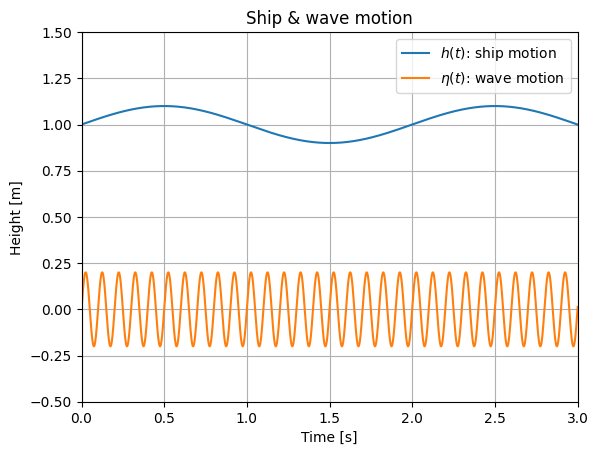

In [22]:
plt.plot(t, h, label='$h(t)$: ship motion')
plt.plot(t, n, label='$\eta(t)$: wave motion')
plt.xlim([0, 3])
plt.ylim([-0.5, 1.5])
plt.title("Ship & wave motion")
plt.xlabel('Time [s]')
plt.ylabel('Height [m]')
plt.legend()
plt.grid()
plt.show()

## Accelerometer
The accelerometer measures vertical accelerations. We can define those as the double derivative of the motion path:

\begin{eqnarray}
    \ddot{h}(t) &=& - 0.4 \pi^2 f_h^2 \sin \left( 2 \pi f_h t\right)
\end{eqnarray}

Accelerometer noise is modeled using a static bias $b$ and a zero-mean gaussian noise $v_a$:

\begin{eqnarray}
    y_a(t) = \ddot{h}(t) + b + v_a(t)
\end{eqnarray}

In [4]:
h_ddot = -0.4 * np.pi**2 * f_h**2 * np.sin(2 * np.pi * f_h * t)

# white noise with desired RMS
v_a = S_a * np.sqrt(fs) * np.random.randn(len(t))

y_a = h_ddot + b + v_a

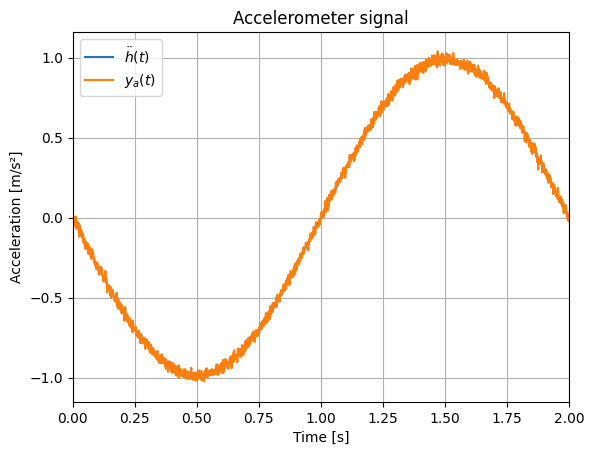

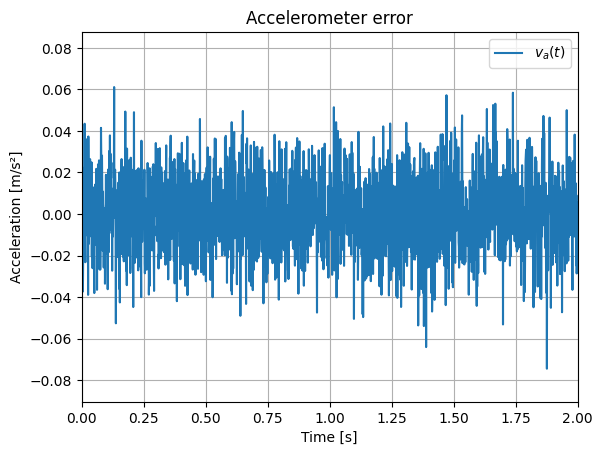

In [25]:
# Plot accelerometer signal
plt.figure()
plt.plot(t, h_ddot, label='$\ddot{h}(t)$')
plt.plot(t, y_a, label='$y_a(t)$')
plt.xlim([0, 2])
plt.title("Accelerometer signal")
plt.xlabel('Time [s]')
plt.ylabel('Acceleration [m/s²]')
plt.legend()
plt.grid()
plt.show()

# Plot accelerometer error
plt.figure()
plt.plot(t, y_a - h_ddot, label='$v_a(t)$')
plt.xlim([0, 2])
plt.title("Accelerometer error")
plt.xlabel('Time [s]')
plt.ylabel('Acceleration [m/s²]')
plt.legend()
plt.grid()
plt.show()

## Height sensor
The height sensor measures the distance from the boat to the water surface, so:

\begin{eqnarray}
    y_h(t) = h(t) - \eta(t)
\end{eqnarray}

In [26]:
y_h = h - n

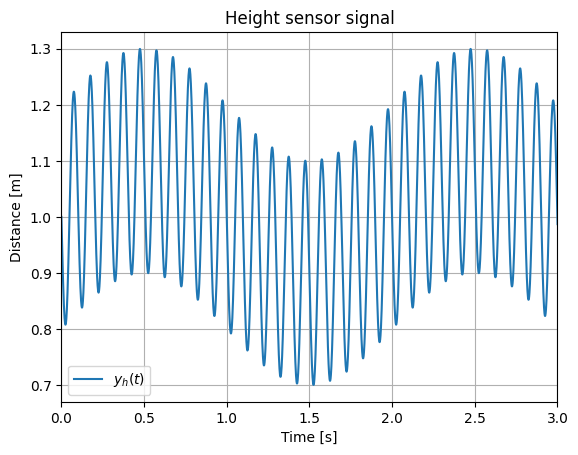

In [28]:
# Plot height sensor signal
plt.figure()
plt.plot(t, y_h, label='$y_h(t)$')
plt.xlim([0, 3])
plt.title("Height sensor signal")
plt.xlabel('Time [s]')
plt.ylabel('Distance [m]')
plt.legend()
plt.grid()
plt.show()

## Double integration of accelerometer signal
Many sensor fusion filters require the accelerometer to be double-integrated into a height signal before the actual filtering. Below, the accelerometer signal $y_a$ is double-integrated, and the result is compared to the actual ship motion to get an idea of the effect of the accelerometer noise and bias. We also investigate the effect of initial conditions on the filter.

**With perfect initial conditions:**

In [29]:
y_a_i = sp.integrate.cumulative_trapezoid(y_a, x=t, initial=0) + np.pi * 0.2 * f_h
h_a = sp.integrate.cumulative_trapezoid(y_a_i, x=t, initial=0) + 1

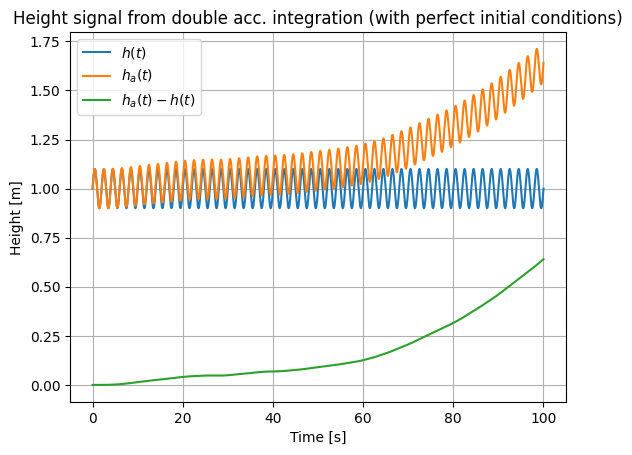

In [30]:
plt.plot(t, h, label='$h(t)$')
plt.plot(t, h_a, label='$h_a(t)$')
plt.plot(t, h_a - h, label='$h_a(t) - h(t)$')
plt.title('Height signal from double acc. integration (with perfect initial conditions)')
plt.xlabel('Time [s]')
plt.ylabel('Height [m]')
plt.legend()
plt.grid()
plt.show()

In practice, the initial conditions are often unknown, and thus set to 0.

**With initial conditions zero:**

In [31]:
y_a_i = sp.integrate.cumulative_trapezoid(y_a, x=t, initial=0)
h_a = sp.integrate.cumulative_trapezoid(y_a_i, x=t, initial=0)

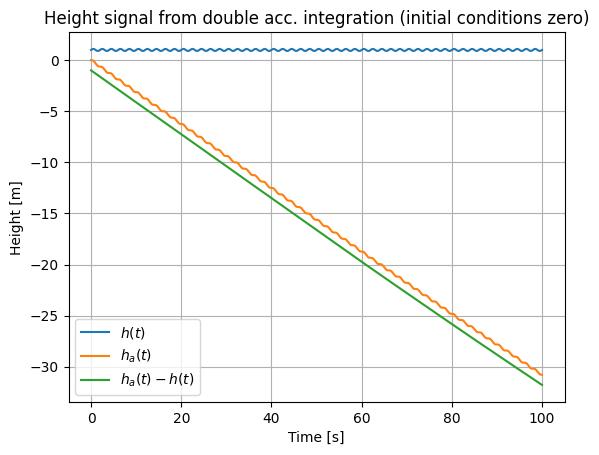

In [32]:
plt.plot(t, h, label='$h(t)$')
plt.plot(t, h_a, label='$h_a(t)$')
plt.plot(t, h_a - h, label='$h_a(t) - h(t)$')
plt.title('Height signal from double acc. integration (initial conditions zero)')
plt.xlabel('Time [s]')
plt.ylabel('Height [m]')
plt.legend()
plt.grid()
plt.show()

## Filter 1: Current FF1 sensor fusion filter
The sensor fusion filter currently implemented in the Flying Fish 1 (FF1) consists of two 2nd-order filters (a lowpass and a highpass). To avoid a notch in the total gain, the filters don't have the same cutoff frequency. The filter cutoff frequencies are shifted to create an 'overlapping' crossover filter (for more information, see the feasibility study chapter in the literature review report).

This filter is defined by a central frequency $f_c=0.2\textrm{Hz}$ and an overlap factor $\kappa=1.5$. Lowpass and highpass filter cutoff frequencies are then defined as:

\begin{eqnarray}
    f_{c,lp} = f_c \cdot \kappa\\
    f_{c,hp} = f_c / \kappa\\
\end{eqnarray}

Below, the bode plot of this filter is shown. Significant gain and phase ripple of the filter is visible.

In [33]:
#Filter constants
order = 2        #  , filter order
f_c = 0.2        #Hz, center frequency
overlap = 1.5    #  , filter overlap (kappa)

b_lp, a_lp = sp.signal.butter(order, f_c*overlap, btype='low', fs=fs)
b_hp, a_hp = sp.signal.butter(order, f_c/overlap, btype='high', fs=fs)

In [34]:
#Filter time series data for performance comparison later

y_h_lp = sp.signal.lfilter(b_lp, a_lp, y_h)                
h_a_hp = sp.signal.lfilter(b_hp, a_hp, h_a)
h_f1 = y_h_lp + h_a_hp;

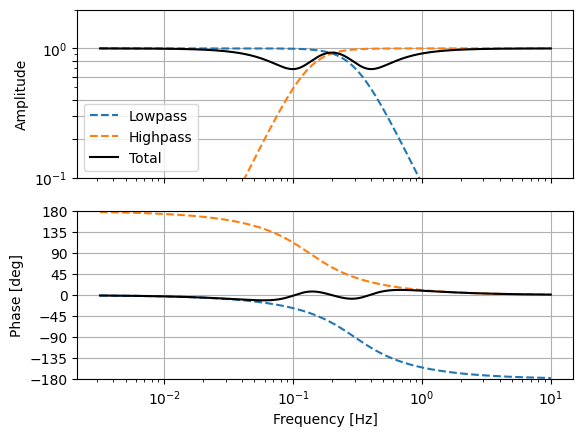

In [35]:
w, h_lp_f1 = sp.signal.freqz(b_lp, a_lp, fs=fs, worN=np.logspace(-2.5, 1.0, 1000))
w, h_hp_f1 = sp.signal.freqz(b_hp, a_hp, fs=fs, worN=np.logspace(-2.5, 1.0, 1000))
h_total_f1 = h_lp_f1 + h_hp_f1

fig, axs = plt.subplots(nrows=2, sharex=True)
axs[0].loglog(w, np.abs(h_lp_f1), label='Lowpass', ls="--")
axs[0].loglog(w, np.abs(h_hp_f1), label='Highpass', ls="--")
axs[0].loglog(w, np.abs(h_total_f1), label='Total', color="k", )
axs[0].set_ylabel('Amplitude')
axs[0].set_yticks([0.1, 0.2, 0.3, 0.4, 0.6, 0.8, 1])
axs[0].set_ylim([0.1, 2])

axs[1].semilogx(w, np.angle(h_lp_f1, deg=True), label='Lowpass', ls="--")
axs[1].semilogx(w, np.angle(h_hp_f1, deg=True), label='Highpass', ls="--")
axs[1].semilogx(w, np.angle(h_total_f1, deg=True), label='Total', color="k")
axs[1].set_ylabel('Phase [deg]')
axs[1].set_xlabel('Frequency [Hz]')
axs[1].set_yticks(np.linspace(-180, 180, 9))
axs[1].set_ylim([-180, 180])

[ax.grid() for ax in axs]
axs[0].legend()

## Filter 2: 2nd-order complementary filter with integrator
For this filter proposal, we will reformulate the 2nd-order complementary filter with an integrator (based on work by Mahony et al., 2008). This results in the following continuous-time formulation:

\begin{eqnarray}
    \hat{h} = \frac{k_P s + k_I}{s^2 + k_P s + k_I}y_h + \frac{s^2}{s^2 + k_P s + k_I}h_a
\end{eqnarray}

This filter is implemented using the bilinear (or Tustin) transformation, with pre-warping applied to correct the central frequency of the filter. 

Below, the bode plot of the filter is shown. It is visible that the filter has unity gain and zero phase across all frequencies, and that there is a 2nd-order attenuation of low-frequency disturbances from the accelerometer. That means that this filter should be able to filter out the quadratic drift caused by the accelerometer bias.

Note that for high values of $k_I$, the central frequency of the filter (estimated from the bode plot) gets shifted to a higher frequency than defined by $f_c$. This effect is not taken into account, so the central frequency of the filter is not exactly 0.2Hz. A correction for this could be developed in further work.

In [36]:
wc = 0.14*2*np.pi #rad/s,   same filter frquency as current FF1 filter: 0.2Hz
ki = 2;          #rad/s^2, integral gain of filter

#Pre-warping of frequency for tusting transform
wc_w = 2*fs*np.tan(wc/(2*fs)) 


zeta = 0.4


# -- With integrator --
num_lp = [0, 2*zeta*wc_w, wc_w**2];
den_lp = [1, 2*zeta*wc_w, wc_w**2];

num_hp = [1, 0, 0];
den_hp = [1, 2*zeta*wc_w, wc_w**2];

b_lp, a_lp = sp.signal.bilinear(num_lp, den_lp, fs)
b_hp, a_hp = sp.signal.bilinear(num_hp, den_hp, fs)
    

# -- Without integrator (for visualization only) --
num_lp = [0, wc_w];
den_lp = [1, wc_w];

num_hp = [1, 0];
den_hp = [1, wc_w];

b_lp_ni, a_lp_ni = sp.signal.bilinear(num_lp, den_lp, fs)
b_hp_ni, a_hp_ni = sp.signal.bilinear(num_hp, den_hp, fs)

In [37]:
#Filter time series data for performance comparison later

y_h_lp = sp.signal.lfilter(b_lp, a_lp, y_h)                
h_a_hp = sp.signal.lfilter(b_hp, a_hp, h_a)
h_f2 = y_h_lp + h_a_hp;

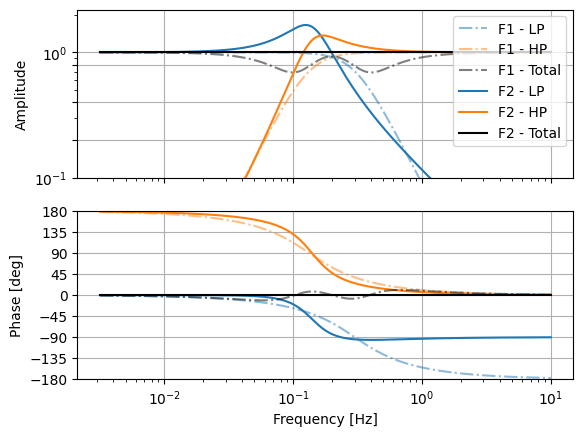

In [38]:
w, h_lp_f2 = sp.signal.freqz(b_lp, a_lp, fs=fs, worN=np.logspace(-2.5, 1.0, 1000))
w, h_hp_f2 = sp.signal.freqz(b_hp, a_hp, fs=fs, worN=np.logspace(-2.5, 1.0, 1000))
h_total_f2 = h_lp_f2 + h_hp_f2

w, h_lp_f2_ni = sp.signal.freqz(b_lp_ni, a_lp_ni, fs=fs, worN=np.logspace(-2.5, 1.0, 1000))
w, h_hp_f2_ni = sp.signal.freqz(b_hp_ni, a_hp_ni, fs=fs, worN=np.logspace(-2.5, 1.0, 1000))
h_total_f2_ni = h_lp_f2_ni + h_hp_f2_ni

fig, axs = plt.subplots(nrows=2, sharex=True)
axs[0].loglog(w, np.abs(h_lp_f1), label='F1 - LP', ls="-.", color="C0", alpha=0.5)
axs[0].loglog(w, np.abs(h_hp_f1), label='F1 - HP', ls="-.", color="C1", alpha=0.5)
axs[0].loglog(w, np.abs(h_total_f1), label='F1 - Total', color="k", ls="-.", alpha=0.5 )
axs[0].loglog(w, np.abs(h_lp_f2), label='F2 - LP', ls="-", color="C0")
axs[0].loglog(w, np.abs(h_hp_f2), label='F2 - HP', ls="-", color="C1")
axs[0].loglog(w, np.abs(h_total_f2), label='F2 - Total', color="k", )
axs[0].set_ylabel('Amplitude')
axs[0].set_yticks([0.1, 0.2, 0.4, 0.8, 1])
axs[0].set_ylim([0.1, 2.2])

axs[1].semilogx(w, np.angle(h_lp_f2, deg=True), label='Lowpass', ls="-", color="C0")
axs[1].semilogx(w, np.angle(h_hp_f2, deg=True), label='Highpass', ls="-", color="C1")
axs[1].semilogx(w, np.angle(h_lp_f1, deg=True), label='Lowpass', ls="-.", color="C0", alpha=0.5)
axs[1].semilogx(w, np.angle(h_hp_f1, deg=True), label='Highpass', ls="-.", color="C1", alpha=0.5)
axs[1].semilogx(w, np.angle(h_total_f1, deg=True), label='Total', ls="-.", color="k", alpha=0.5)
axs[1].semilogx(w, np.angle(h_total_f2, deg=True), label='Total', color="k")
axs[1].set_ylabel('Phase [deg]')
axs[1].set_xlabel('Frequency [Hz]')
axs[1].set_yticks(np.linspace(-180, 180, 9))
axs[1].set_ylim([-180, 180])

[ax.grid() for ax in axs]
axs[0].legend()

## Performance comparison

Below, the filters are used to estimate the ship's motion, and the results of the different filters are compared.

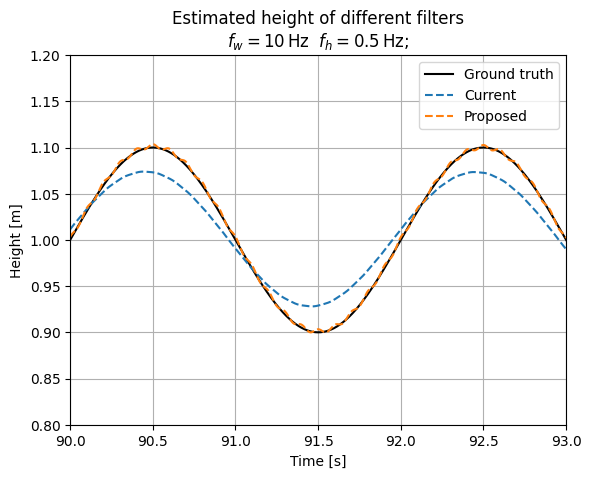

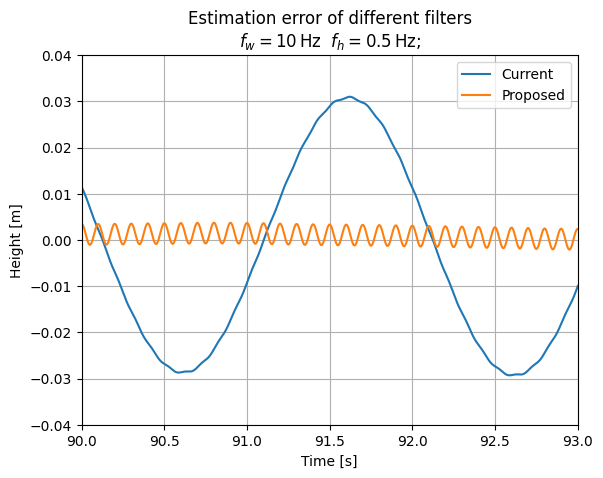

In [39]:
plt.figure()
plt.plot(t, h, label='Ground truth', color="k")
plt.plot(t, h_f1, label='Current', color="C0", ls="--")
plt.plot(t, h_f2, label='Proposed', color="C1", ls="--")
plt.title('Estimated height of different filters\n'
          fr'$f_w = {f_w}\,\mathrm{{Hz}}$  $f_h = {f_h}\,\mathrm{{Hz}}$;')
plt.xlabel('Time [s]')
plt.ylabel('Height [m]')
plt.xlim([90,93])
plt.ylim([0.8, 1.2])
plt.legend()
plt.grid()
plt.show()

plt.figure()
plt.plot(t, h_f1 - h, label='Current')
plt.plot(t, h_f2 - h, label='Proposed')
plt.title(f'Estimation error of different filters\n'
          fr'$f_w = {f_w}\,\mathrm{{Hz}}$  $f_h = {f_h}\,\mathrm{{Hz}}$;')
plt.xlabel('Time [s]')
plt.ylabel('Height [m]')
plt.xlim([90,93])
plt.ylim([-0.04, 0.04])
plt.legend()
plt.grid()
plt.show()

In [40]:
#Exclude first 30s to let estimators converge
mask = (t >= 30) & (t <= 100)

rmse_f1 = np.sqrt(np.mean((h_f1[mask] - h[mask])**2))
rmse_f2 = np.sqrt(np.mean((h_f2[mask] - h[mask])**2))
print(f"RMSE f1: {rmse_f1:.4f} [m]")
print(f"RMSE f2: {rmse_f2:.4f} [m]")

RMSE f1: 0.0211 [m]
RMSE f2: 0.0017 [m]
